In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

# D = 1

In [2]:
def normal_density(x, mean = 0, sd = 1):
  return (1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x-mean)**2*sd**2)

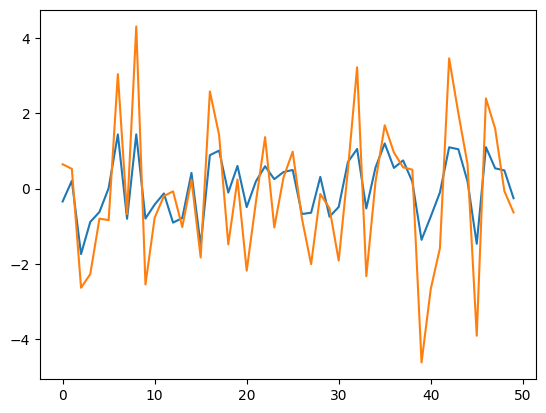

In [3]:
#simulate some data following a linear gaussian equation
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
T = 50
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))
  Z.append([X[t], Y[t]])

plt.plot(Z)

**kalman filter**

In [4]:
estimate_mu_x = [npr.normal(0,1)]
estimate_sigma_x = [npr.normal(0,1)]
res = [[estimate_mu_x[0], X[0]]]

In [5]:
#implement the kalman filter
def kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X):
  for t in range (1,len(Y)):
    estimate_mu_x.append(a*estimate_mu_x[t-1])
    estimate_sigma_x.append(a**2*estimate_sigma_x[t-1] + var_eps)
    estimate_mu_x[t] = estimate_mu_x[t] + estimate_sigma_x[t]*b*(Y[t]-b*estimate_mu_x[t-1])/(b**2*estimate_sigma_x[t] + var_delta)
    estimate_sigma_x[t] = estimate_sigma_x[t] - estimate_sigma_x[t]**2*b**2/(b**2*estimate_sigma_x[t] + var_delta)
    res.append([estimate_mu_x[t], X[t]])
  return(res, estimate_mu_x, estimate_sigma_x)

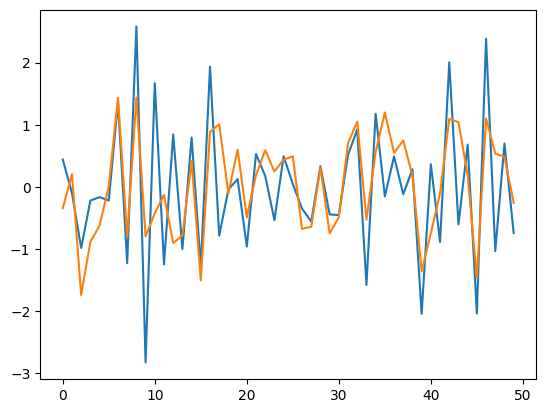

In [6]:
res = kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X)
to_plot = res[0]
x_values = res[1]
plt.plot(to_plot)

**Bootstrap PF**

In [7]:
#implement the bootstrap filter (smc)
def multinomial_resampling(w , x):
  u = npr.rand(*w.shape)
  bins = np.cumsum(w)
  indices = np.digitize(u, bins)
  return (x[indices], indices)

def normal_density_vector(x, mean = 0, sd = 1):
    res = []
    for i in range (len(x)):
      res.append((1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x[i]-mean)**2*sd**2))
    return (res)


def step(x_previous, weights_previous, Y_observed, a, var_eps, var_delta, b):
  #resample
  test = multinomial_resampling(weights_previous, x_previous)
  resample = test[0] #multinomial resampling of the particles
  indices = test[1]
  #propagate
  x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
  #compute weights
  w = np.empty(len(x))
  for i in range (len(x)):
    w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))
  return (x, w, sum(w*x)/sum(w), indices)

def bootstrap_filter(x, w, Y, a, var_eps, var_delta,b):
  estimate = [np.mean(x[0])]
  res = []
  indices = [[0,1,2]]
  ESS = []
  for t in range (1,len(Y)):
      res = step(x[t-1], w[t-1], Y[t], a, var_eps, var_delta,b)
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)


In [8]:
N = 3 #particles
T = 50
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])


In [9]:
res_algo = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)

res_smc = res_algo[2]

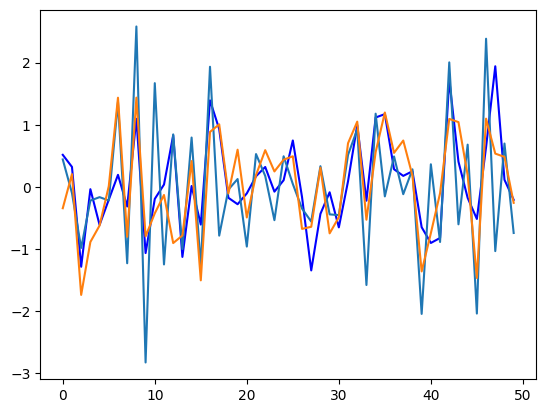

In [10]:
plt.plot(res_smc, color = 'blue')
plt.plot(to_plot)

**Plot the particles behaviour**

In [11]:
res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
particles = res[0]
estimate = res[2]
indices = res[3]

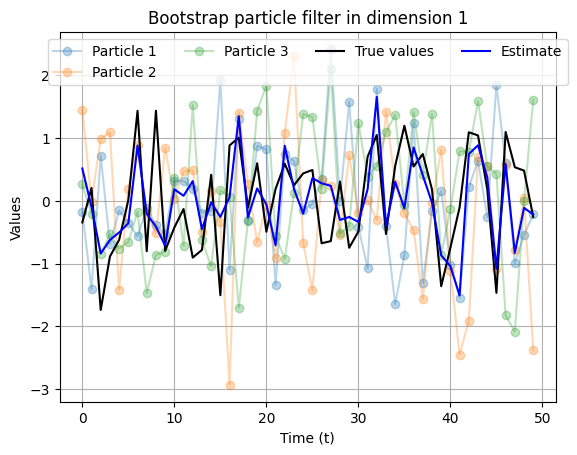

In [12]:
x_abs = np.array([i for i in range(T)])
for i in range(particles.shape[1]):
    plt.plot(x_abs, particles[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
plt.plot(X, color = 'black', label = 'True values')
plt.plot(estimate, color = 'blue', label = 'Estimate')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Bootstrap particle filter in dimension 1')
plt.legend(loc = 'upper center', ncols = 4)
plt.grid(True)
plt.show()

plot the path

In [13]:
def path(particle_to_track, particles, indices):
    T = len(particles)
    ancestor_index = indices[T-1][particle_to_track]
    ancestor_value = [particles[T-1][particle_to_track], particles[T-2][ancestor_index]]
    for i in range (2, T):
        ancestor_index = indices[T-i][ancestor_index]
        ancestor_value.append(particles[T-i-1][ancestor_index])
    return(ancestor_value)


In [14]:
def plot_paths(particles, indices):
    N = len(particles[0]) #number of particles
    res = np.empty([N, T])
    abs = [i for i in range (T)]
    for k in range (N):
        res[k] = path(k, particles, indices)
    for i in range (N):
        plt.plot(abs, res[i][::-1], label = 'Particle {}'.format(i+1)) #add title and labels
    #plt.xticks(abs)
    plt.title('Particles paths')
    plt.xlabel('Time(t)')
    plt.ylabel('Values')
    plt.grid(True)
    #plt.legend()

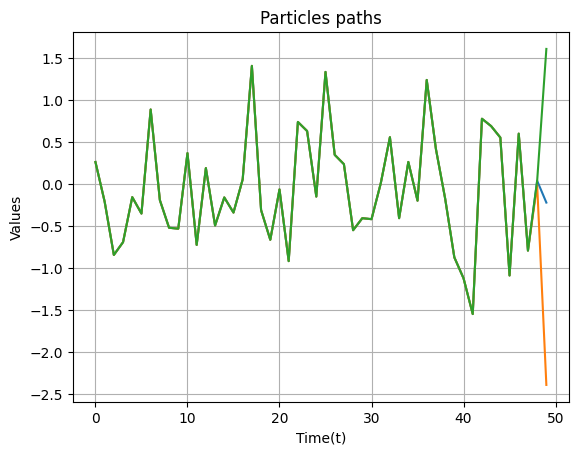

In [15]:
plot_paths(particles, indices)

The final particles all came from the same particle so they all have the same path. Let's see if we increase the number of particles what happens. 

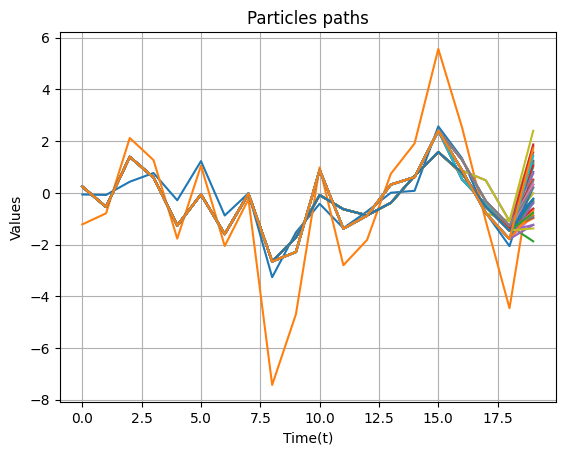

In [16]:
#simulate some data following a linear gaussian equation
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
T = 20
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))
  Z.append([X[t], Y[t]])

plt.plot(Z)

N = 40 #particles
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])

res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
particles = res[0]
estimate = res[2]
indices = res[3]

plot_paths(particles, indices)

In [17]:
#weights
#bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[1]

ESS

Let's look at the ESS for different values of N 

In [18]:
N_max = 100
plot = []
sd = []

for N in range (1, N_max):
    T = 50
    smc_x = np.empty([T,N])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])

    res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
    ESS = res[4]
    plot.append(np.mean(ESS)*2/N)
    sd.append(np.std(ESS))

Text(0.5, 1.0, 'Avergae ESS divided by N/2')

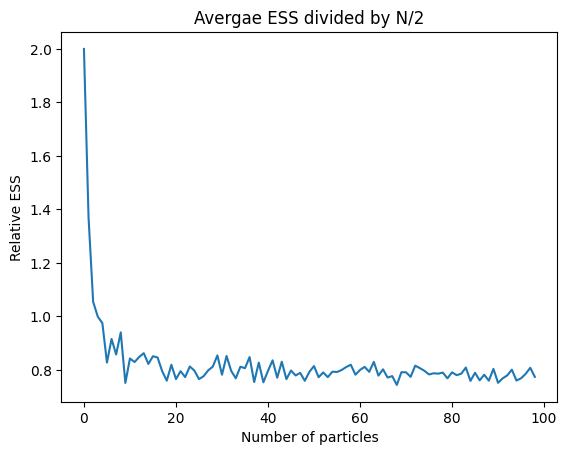

In [19]:
abs = [i for i in range (1, N_max)]
#plt.plot(np.log(abs), np.log(plot))
plt.plot(plot)
plt.xlabel('Number of particles')
plt.ylabel('Relative ESS')
plt.title('Avergae ESS divided by N/2')

Take into account the ESS in the BPF

In [100]:
def step_ess(x_previous, weights_previous, Y_observed, a, var_eps, var_delta, b, ESS_t, indices_t):
  N = len(x_previous)
  w = np.empty(len(x_previous))
  #resample
  if ESS_t <= N/3 :
    test = multinomial_resampling(weights_previous, x_previous)
    resample = test[0] #multinomial resampling of the particles
    indices = test[1]
    #propagate
    x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
    #compute weights
    for i in range (len(x)):
      w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))
  else :
    resample = x_previous
    indices = indices_t
    #propagate
    x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
    #compute weights
    for i in range (len(x)):
      w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))*np.array(weights_previous[i])*N
  
  return (x, w, sum(w*x)/sum(w), indices)

def bpf_ess(x, w, Y, a, var_eps, var_delta,b):
  N = len(x[0])
  estimate = [np.mean(x[0])]
  res = []
  indices = [np.array([i for i in range (N)])]
  ESS = [0]
  for t in range (1,len(Y)):
      res = step_ess(x[t-1], w[t-1], Y[t], a, var_eps, var_delta,b, ESS[t-1], indices[t-1])
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)


In [101]:
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [y0]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))


N = 30
T = 50
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])

res = bpf_ess(smc_x, smc_w, Y, a, var_eps, var_delta,b)

In [102]:
particles = res[0]
weights = res[1]
estimate = res[2]
indices = res[3]
ESS = res[4]

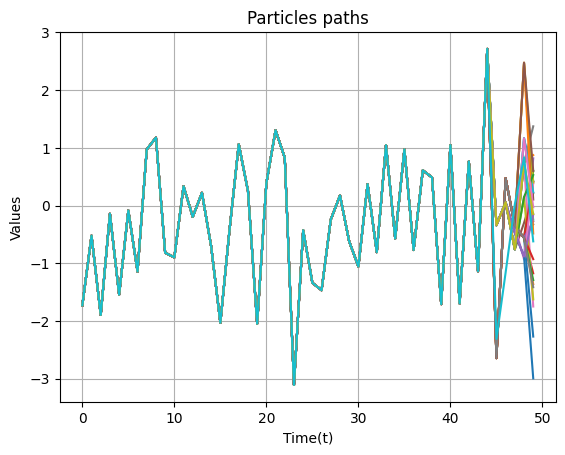

In [103]:
plot_paths(particles, indices)

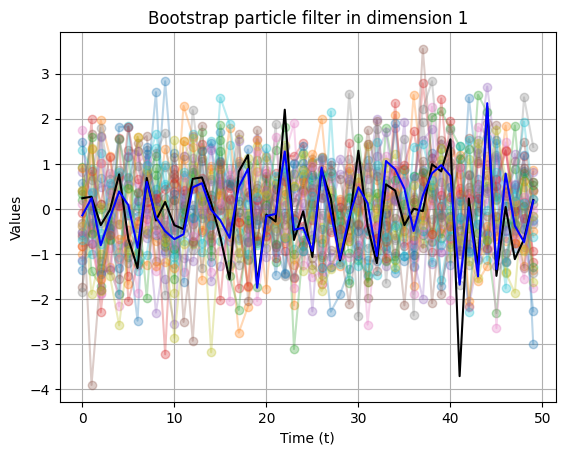

In [104]:
x_abs = np.array([i for i in range(T)])
for i in range(particles.shape[1]):
    plt.plot(x_abs, particles[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
plt.plot(X, color = 'black', label = 'True values')
plt.plot(estimate, color = 'blue', label = 'Estimate')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Bootstrap particle filter in dimension 1')
#plt.legend(loc = 'upper center', ncols = 4)
plt.grid(True)
plt.show()

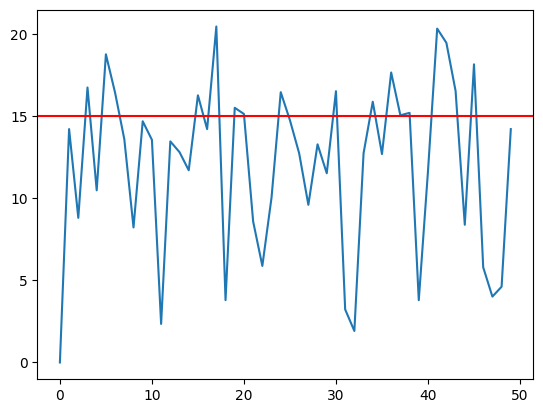

In [25]:
plt.plot(np.array(ESS))
plt.axhline(y = N/2, color = 'r', linestyle = '-')

Compare the algorithm with and without the ESS ? 

In [26]:
def compare_ess_dim1(N, T, a, b, var_eps, var_delta):
  #simulate the data
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot_smc = []
  to_plot_smc_ess = []

  #bpf
  for k in range (1, N):
    smc_x = np.empty([T,k])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (k)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])
    res_smc_ess = np.array(bpf_ess(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE_smc = np.sqrt(np.mean((res_smc - X)**2))
    to_plot_smc.append(RMSE_smc)

    RMSE_ess = np.sqrt(np.mean((res_smc_ess - X)**2))
    to_plot_smc_ess.append(RMSE_ess)


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex = True)
  ax2.plot(absciss[1:], to_plot_smc, label = 'Without ESS')
  ax2.plot(absciss[1:], to_plot_smc_ess, label = 'With ESS')
  ax1.plot(absciss[1:], np.array(to_plot_smc) - np.array(to_plot_smc_ess), label = 'Difference between without and with ESS')
  ax1.axhline(y = 0, color = 'r', linestyle = '-')
  plt.xlabel('Number of particles')
  ax1.set_ylabel('RMSE with the true X')
  ax2.set_ylabel('Difference between without and with ESS')
  ax1.grid(True)
  fig.suptitle('BPF vs BPF with ESS')
  plt.legend()
  plt.tight_layout()
  plt.grid(True)
  plt.show()

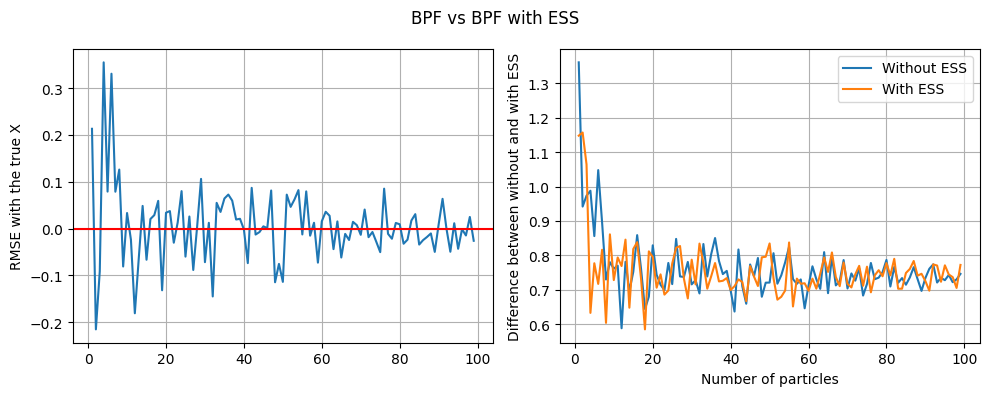

In [27]:
compare_ess_dim1(100, 10, 0.5, 0.75, 1, 1)

it could be useful to average over a certain number of rounds for each number of particles in order to have smoother curves

compare the variance of the estimators since that's the goal, to reduce the variance

In [28]:
def var(seq1):
    res = []
    seq1 = np.array(seq1).transpose()
    for i in range (len(seq1)):
        res.append(np.std(seq1[i]))
    return(np.mean(res))

In [29]:
def var2(seq1, i):
    res = []
    seq1 = np.array(seq1).transpose()
    return(np.std(seq1[i]))

In [30]:
def variance_smc_ess(N, T, a, b, var_eps, var_delta, n_rounds, i):
    #simulate the data
    x0 = npr.normal(0,1)
    y0 = npr.normal(0,1)

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(a*X[t-1] + npr.normal(0,var_eps**2))
        Y.append(b*X[t] + npr.normal(0,var_delta**2))

    T = len(Y)
    absciss = np.array([i for i in range (N)])
    to_plot_smc = []
    to_plot_ess = []
    interm_smc = []
    interm_ess = []

    #bpf
    for k in range (1, N):
        for z in range (n_rounds):
            smc_x = np.empty([T,k])
            smc_w = np.empty([T,k])
            smc_x[0] = np.array([[npr.normal(0,1) for i in range (k)]]) #for each time we have N particles which have a value
            smc_w[0] = np.array([[1/k for i in range (k)]])
            res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])
            res_smc_ess = np.array(bpf_ess(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])
            interm_smc.append(res_smc)
            interm_ess.append(res_smc_ess)
        #print(np.array(interm_ess).transpose())
        #print(interm_ess)
        #to_plot_smc.append(var2(interm_smc, i))
        #to_plot_ess.append(var2(interm_ess, i))
        to_plot_smc.append(var(interm_smc))
        to_plot_ess.append(var(interm_ess))
        interm_smc = []
        interm_ess = []
    
    #plot
    abs = np.array([k for k in range (1, N)])
    plt.plot(np.log(abs), np.log(to_plot_smc), label = 'without ess')
    plt.plot(np.log(abs), np.log(to_plot_ess), label = 'with ess')
    plt.grid(True)
    plt.legend()
    


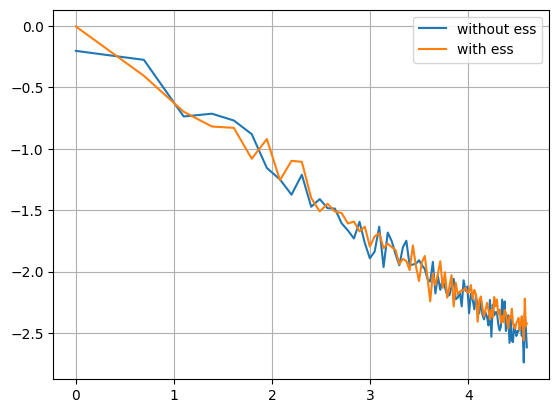

In [31]:
variance_smc_ess(100, 10, 0.5, 0.75, 1, 1, 10, 3)

We also want to compare if introducing this adaptive resampling avoids the path degeneracy. 

In [105]:
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
a = 1
b = 0.5
var_eps = 1
var_delta = 1
N = 100
T = 15

X = [x0]
Y = [y0]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))


smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])



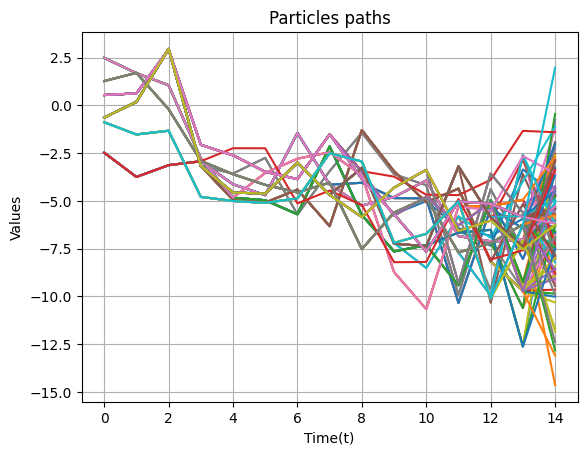

In [109]:
res = bpf_ess(smc_x, smc_w, Y, a, var_eps, var_delta,b)

particles = res[0]
weights = res[1]
estimate = res[2]
indices = res[3]
ESS = res[4]

plot_paths(particles, indices)

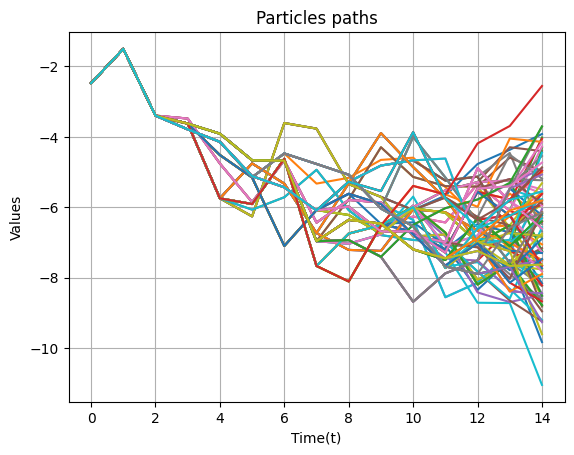

In [111]:
res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)

particles = res[0]
weights = res[1]
estimate = res[2]
indices = res[3]
ESS = res[4]

plot_paths(particles, indices)

**Plot the RMSE between kalman and BPF for increasing number of particles (BPF should converge to the kalman filter)**

In [35]:
def plot_kalman_smc_N(N, T, a, b, var_eps, var_delta):
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot = []
  estimate_mu_x = [npr.normal(0,1)]
  estimate_sigma_x = [npr.normal(0,1)]
  res = [[estimate_mu_x[0], X[0]]]
  res = np.array(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X)[1])
  for k in range (1, N):
    smc_x = np.empty([T,k])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (k)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE = np.sqrt(np.mean((res_smc - res)**2))

    to_plot.append(RMSE)

  plt.plot(np.log(absciss[1:]), np.log(to_plot))
  plt.xlabel('Number of particles')
  plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Convergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


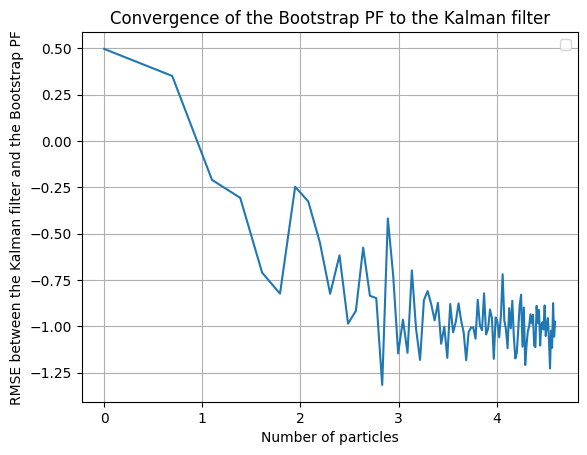

In [36]:
plot_kalman_smc_N(100, 10, 0.5, 0.75, 1, 1)

**Average over 5 or 10 rounds for each N**

In [37]:
def boucle_average(n_rep, res, T, N, a, b, var_eps, var_delta, Y):
  to_return = []
  for i in range (n_rep):
    smc_x = np.empty([T,N])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE = np.sqrt(sum((res_smc - res)**2)/N)

    to_return.append(RMSE)

    return(np.mean(np.array(to_return)))


In [38]:
def plot_kalman_smc_N_2(N, T, a, b, var_eps, var_delta, n_rep):
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot = []
  estimate_mu_x = [npr.normal(0,1)]
  estimate_sigma_x = [npr.normal(0,1)]
  res = [[estimate_mu_x[0], X[0]]]
  res = np.array(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X)[1])
  for k in range (1, N):
    RMSE = boucle_average(n_rep, res, T, k, a, b, var_eps, var_delta, Y)

    to_plot.append(RMSE)

  plt.plot(np.log(absciss[1:]), np.log(to_plot))
  plt.xlabel('Log of the number of particles')
  plt.ylabel('Log of the RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Covergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


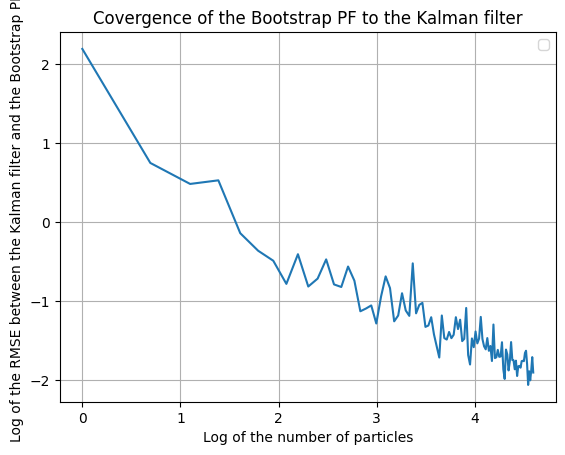

In [39]:
plot_kalman_smc_N_2(100, 10, 0.5, 0.75, 1, 1, 10) #average on 10 rounds 

**Comparison for different values of T of Kalman and the particle filter**

In [40]:
def RMSE(sequence, true_values):
  return (np.sqrt(sum((sequence-true_values)**2)/len(sequence)))

In [41]:
#algorithm that does everything
def kalman_boostrap_simulate(T_max, N, a, b, var_eps = 1, var_delta = 1):
  #arbitrarily initialize everything at 0
  RMSE_kalman = [0]
  RMSE_bootstrap = [0]
  res_boot = [0]
  res_kalman = [0]

  #kalman filter and boostrap filter for each t
  for k in range (1, T_max):
    #simulate the true data
    x0 = npr.normal(0,1)
    y0 = npr.normal(0,1)
    X = [x0]
    Y = [y0]
    Z = [[x0, y0]]
    for t in range (1,k):
      X.append(a*X[t-1] + npr.normal(0,var_eps**2))
      Y.append(b*X[t] + npr.normal(0,var_delta**2))
      Z.append([X[t], Y[t]])

    #kalman and bootstrap for iteration k
    smc_x = np.empty([k,N])
    smc_w = np.empty([k,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])

    estimate_mu_x = [npr.normal(0,1)]
    estimate_sigma_x = [npr.normal(0,1)]
    res = [[estimate_mu_x[0], X[0]]]
    
    res_kalman.append(kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X)[1])
    res_boot.append((bootstrap_filter(x = smc_x, w = smc_w, Y = Y, a = a, var_eps = var_eps, var_delta = var_delta, b=b))[2])

    RMSE_kalman.append(RMSE(np.array(res_kalman[k]), np.array(X)))
    RMSE_bootstrap.append(RMSE(np.array(res_boot[k]), np.array(X)))

  return (RMSE_kalman, RMSE_bootstrap) #warning : do not take the first value for each (initialized at 0)


In [42]:
to_plot = kalman_boostrap_simulate(30, 10, 0.8, 0.7)

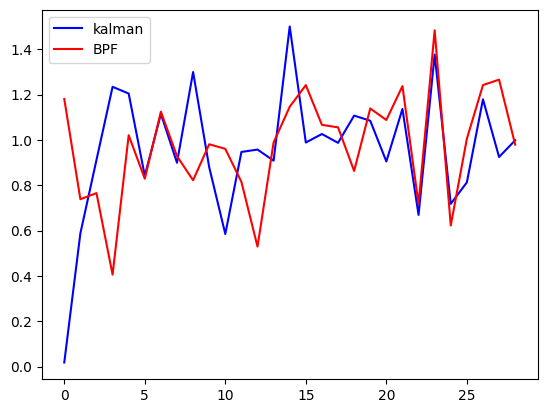

In [43]:
plt.plot(to_plot[0][1:], color = 'blue', label = 'kalman') #kalman
plt.plot(to_plot[1][1:], color = 'red', label = 'BPF') #PF
plt.legend()

In [44]:
def kalman_boostrap_simulate_wip(T_max, N = 10, a = 0.7, b = 0.5, var_eps = 1, var_delta = 1, n_mean = 15):
  #arbitrarily initialize everything at 0
  RMSE_kalman = []
  RMSE_bootstrap = []
  res_boot = []
  res_kalman = []
  RMSE_kalman_for_round = []
  RMSE_boot_for_round = []

  #kalman filter and boostrap filter for each t
  for k in range (1, T_max):
    for z in range (n_mean):
      #simulate the true data
      x0 = npr.normal(0,1)
      y0 = npr.normal(0,1)
      X = [x0]
      Y = [y0]
      Z = [[x0, y0]]
      for t in range (1,k):
        X.append(a*X[t-1] + npr.normal(0,var_eps**2))
        Y.append(b*X[t] + npr.normal(0,var_delta**2))
        Z.append([X[t], Y[t]])

      #kalman and bootstrap for iteration k
      smc_x = np.empty([k,10])
      smc_w = np.empty([k,10])
      smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
      smc_w[0] = np.array([[1/N for i in range (N)]])

      estimate_mu_x = [npr.normal(0,1)]
      estimate_sigma_x = [npr.normal(0,1)]
      res = [[estimate_mu_x[0], X[0]]]

      res_kalman = kalman_1_d(estimate_mu_x, estimate_sigma_x, res, a, b, Y, X)[1]
      res_boot = bootstrap_filter(x = smc_x, w = smc_w, Y = Y, a = a, var_eps = var_eps, var_delta = var_delta, b=b)[2]

      RMSE_kalman_for_round.append(RMSE(np.array(res_kalman), np.array(X)))
      RMSE_boot_for_round.append(RMSE(np.array(res_boot), np.array(X)))

    RMSE_kalman.append(np.mean(np.array(RMSE_kalman_for_round)))
    RMSE_bootstrap.append(np.mean(np.array(RMSE_boot_for_round)))
    #RMSE_kalman.append(RMSE(np.array(res_kalman[k]), np.array(X)))
    #RMSE_bootstrap.append(RMSE(np.array(res_boot[k]), np.array(X)))
    res_boot = []
    res_kalman = []
    RMSE_kalman_for_round = []
    RMSE_boot_for_round = []

  return (RMSE_kalman, RMSE_bootstrap) #warning : do not take the first value for each (initialized at 0)


In [45]:
to_plot = kalman_boostrap_simulate_wip(100)

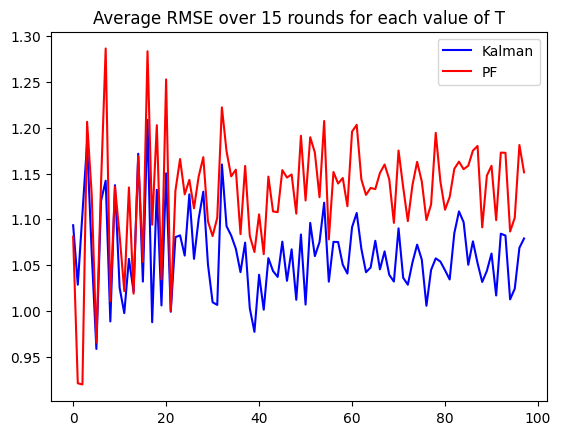

In [46]:
plt.plot(to_plot[0][1:], color = 'blue', label = 'Kalman') #kalman
plt.plot(to_plot[1][1:], color = 'red', label = 'PF') #PF
plt.title("Average RMSE over 15 rounds for each value of T")
plt.legend()

In blue, the kalman filter RMSE, in red the bootstrap filer RMSE. In absciss, T the time.

# Dimension D

Let A the matrix such that $x_{t} = A x_{t-1} + \epsilon$. \
Let C the matrix such that $y_{t} = B x_{t} + \delta$.\
$\epsilon \sim N(0,Q)$ and $\delta \sim N(0,R)$.

initial belief : x and y $\sim N(0,1)$

**Data simulation**

In [47]:
#simulate data
D = 3 #dimension
#simulate some data following a linear gaussian equation
x0 = np.array([npr.normal(0,1) for i in range (D)])
y0 = np.array([npr.normal(0,1) for i in range (D)])
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = np.identity(D)

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
  Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
  Z.append([X[t], Y[t]])

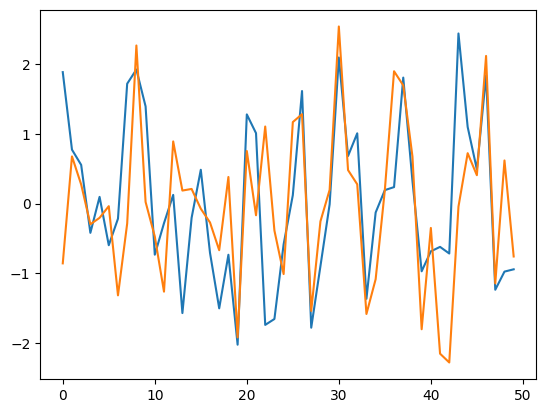

In [48]:
#plot the evolution of the coordinates of X and Y
plt.plot(np.array(X).transpose()[0])
#plt.plot(np.array(X).transpose()[1])
plt.plot(np.array(Y).transpose()[0])

**Kalman filter**

In [49]:
#mu_x and sigma_x contain only the initial value
mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
sigma_x = np.array([np.identity(D)])

In [50]:
#kalman filter
def kalman_filter_d(mu_x, sigma_x, A, C, Q, R, true_Y, T):
  for t in range (1, T):
    #prediction
    mu_x = np.vstack([mu_x, (np.dot(A, mu_x[t-1]))])
    sigma_x = np.append(sigma_x, np.array([np.dot(np.dot(A, sigma_x[t-1]),A.transpose()) + Q]), axis= 0)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x[t]), C.transpose()) + R))
    mu_x[t] = mu_x[t] + np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), (true_Y[t] - np.dot(C, mu_x[t])))
    sigma_x[t] = sigma_x[t] - np.dot(np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), C), sigma_x[t])
    #x_values = np.vstack([x_values,npr.multivariate_normal(mu_x[t], sigma_x[t])]) #useless
  return (mu_x, sigma_x)

In [51]:
res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)

In [52]:
mu_x = res[0]
sigma_x = res[1]

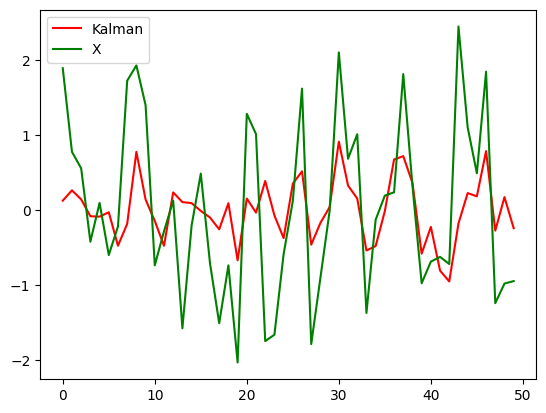

In [53]:
#plot the first coordinate of X and the estimations with the Kalman filter
plt.plot(mu_x.transpose()[0], color = 'red', label = 'Kalman')
plt.plot(np.array(X).transpose()[0], color = 'green', label = 'X')
plt.legend()

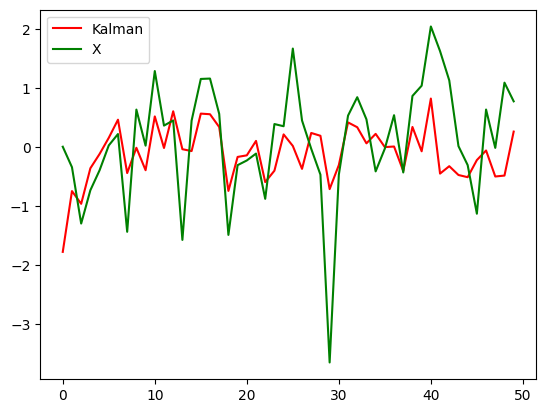

In [54]:
#plot the 2nd coordinate of X and the estimations with the Kalman filter
plt.plot(mu_x.transpose()[1], color = 'red', label = 'Kalman')
plt.plot(np.array(X).transpose()[1], color = 'green', label = 'X')
plt.legend()

**Bootstrap particle filter**

In [55]:
from scipy.stats import multivariate_normal
def normal_density_vector_d(x, mean, sd):
   return(multivariate_normal.pdf(x, mean = mean, cov= sd))

In [56]:
N = 10 #particles
smc_x = np.array([np.empty([D,N]) for i in range (T)])
smc_w = np.empty([T,N])
smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])

In [57]:
#implement the bootstrap filter in high dimension
def multinomial_resampling_d(vectors, weights, num_samples):
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    # Resample indices
    indices = np.random.choice(np.arange(len(vectors)), size=num_samples, p=normalized_weights)
    # Resampled vectors
    resampled_vectors = vectors[indices]
    return resampled_vectors.transpose()


from scipy.stats import multivariate_normal
def normal_density_vector_d(x, mean, sd): #it works
   return(multivariate_normal.pdf(x, mean = mean, cov= sd))

def step_d(x_previous, weights_previous, Y_observed, A, var_eps, var_delta, D, N,B): #now we have matrices and vectors, D is the dimension, x_previous is going to be smc_x[t] for iteration t, Y_observed is Y[t]
  #resample #generate  xt-1^i_resampled equally weighted by resampling
  resample = multinomial_resampling_d(x_previous.transpose(),weights_previous, num_samples = N) #multinomial resampling of the particles
  #resample = x_previous #TO DO : multionimal resampling
  #propagate #sample xt^i from p(xt | xt-1^i_resampled)
  x = np.empty([D,N])
  for i in range(N):
    x[:,i] = np.array(np.dot(A, resample[:,i]) + npr.multivariate_normal(np.zeros(D), var_eps)) #creates an array for each i of dimension d
  #compute weights #p(yt|xt^i)
  w = np.empty(N)
  for i in range(N):
    w[i] = np.array(normal_density_vector_d(Y_observed, mean = np.dot(B,x[:,i]), sd = var_delta))
  w_norm = w/sum(w)
  #estimate
  estimate = np.array([0 for i in range (D)])
  for i in range(N):
    estimate = estimate + np.array(w_norm[i]*x[:,i]) #colonne de 3 ok
  return (x, w_norm, estimate)


In [58]:
def bootstrap_filter_d(x, w, Y, T, A, var_eps, var_delta, D, N,B):
  estimate = [np.zeros(D)] #valeurs de X donc ça doit être une collection de vecteurs de dimension d dans une matrice de dimension T
  res = []
  for t in range (1,T):
    res = step_d(x[t-1], w[t-1], Y[t], A, var_eps, var_delta, D, N,B)
    x[t] = np.array(res[0])
    w[t] = np.array(res[1]) #normalized weights
    estimate.append(res[2])
  return(x,w,estimate)

In [59]:
res = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, N,B)

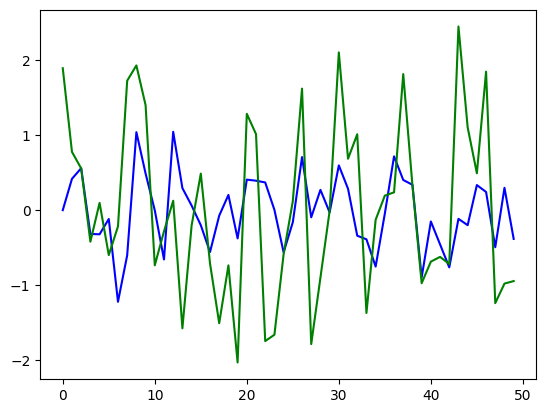

In [60]:
plt.plot(np.array(res[2]).transpose()[0], color = 'blue')
plt.plot(np.array(X).transpose()[0], color = 'green')

In blue : the boostrap PF, in green the real values of X. I only represented the first coordinate of X.

In [61]:
weights = res[1].transpose()

In [62]:
ESS = np.array(1/np.sum(weights**2, axis = 0))

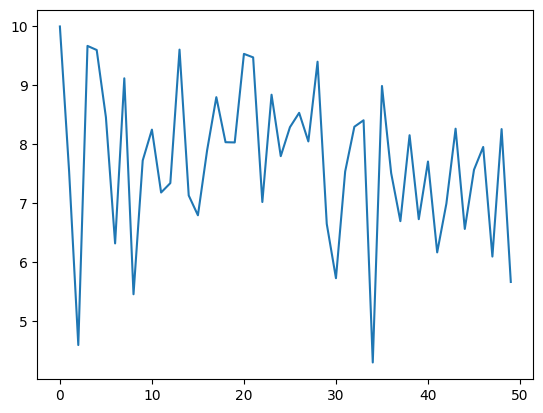

In [63]:
plt.plot(ESS) #10 particles here 

*Plot PF and Kalman filter results*

In [64]:
#algorithm that does everything in dimension D
def kalman_boostrap_simulate(T_max, D, N = 10, A = 0.2*np.identity(D), B = 0.4*np.identity(D), var_eps = np.identity(D), var_delta = np.identity(D)):
  #arbitrarily initialize everything at 0

  #simulate the true data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])
  X = [x0]
  Y = [y0]
  Z = [[x0, y0]]
  for t in range (1,T_max):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    Z.append([X[t], Y[t]])

  #kalman and bootstrap
  smc_x = np.array([np.empty([D,N]) for i in range (T_max)])
  smc_w = np.empty([T_max,N])
  smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
  smc_w[0] = np.array([[1/N for i in range (N)]])

  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  x_values = np.array([x0])

  res_kalman = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T_max)
  res_boot = bootstrap_filter_d(smc_x, smc_w, Y, T_max, A, var_eps, var_delta, D, N,B)
  mu_kalman = res_kalman[0]
  sd_kalman = res_kalman[1]
  #values_kalman = res_kalman[0]
  values_boot = res_boot[2]
  particles = res_boot[0]

  return (mu_kalman, sd_kalman, values_boot, particles, X, Y)


In [65]:
D = 5
res = kalman_boostrap_simulate(50, D, N = 3, A = 0.2*np.identity(D), B = 0.4*np.identity(D), var_eps = np.identity(D), var_delta = np.identity(D))
mean = res[0]
sigma = res[1]
values_boot = res[2]
particles = res[3]
true_X = res[4]
true_Y = res[5]

In [66]:
#for i in range (len(particles)): #len(particles) représente le temps
  #print(particles[i][:,0]) #donne la colonne 0 cad le vecteur de la premiere particule avec ses D coordonnées
  #print(particles[i][0]) #donnes les 10 particules sur la coordonnée 0

In [67]:
#plotting the results for any coordinate
def plot_results(coordinate, particles, true_X, values_boot, sigma, mean):
  T = len(true_X)
  to_plot_coordinate = [particles[0][coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i][coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  for i in range(to_plot_coordinate.shape[1]):
    plt.plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.5)
  plt.plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  plt.plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with PF')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  plt.errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman')
  plt.xlabel('Time (t)')
  plt.ylabel('Particles')
  plt.title('Coordinate {}'.format(coordinate+1))
  plt.legend()
  plt.grid(True)
  plt.show()


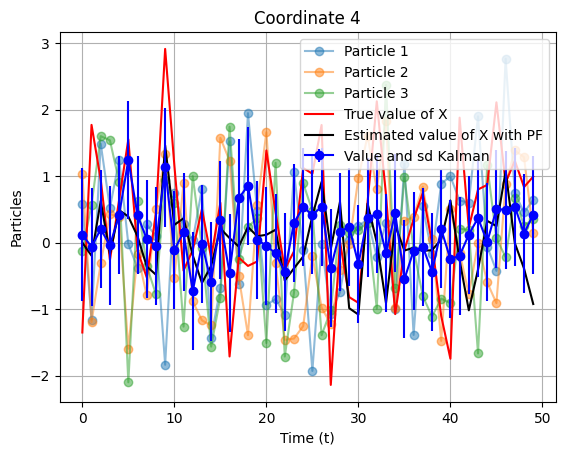

In [68]:
plot_results(3, particles, true_X, values_boot, sigma, mean)

In [69]:
#plotting the results for any coordinate
def plot_results_2(coordinate, particles, true_X, values_boot, sigma, mean):
  T = len(true_X)
  to_plot_coordinate = [particles[0][coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i][coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  for i in range(to_plot_coordinate.shape[1]):
    axs[0].plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
  axs[0].plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  axs[0].plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with PF')
  axs[0].set_xlabel('Time (t)')
  axs[0].set_ylabel('Particles')
  axs[0].set_title('Coordinate {}'.format(coordinate+1))
  axs[0].legend()

  axs[1].plot(np.array(true_X).transpose()[1], color='red', label='True value of X')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  axs[1].errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman', alpha = 0.3)
  axs[1].set_xlabel('Time (t)')
  axs[1].set_ylabel('Estimates')
  axs[1].set_title('Coordinate {}'.format(coordinate+1))
  axs[1].legend()

  plt.tight_layout()

  # Show the plot
  plt.show()


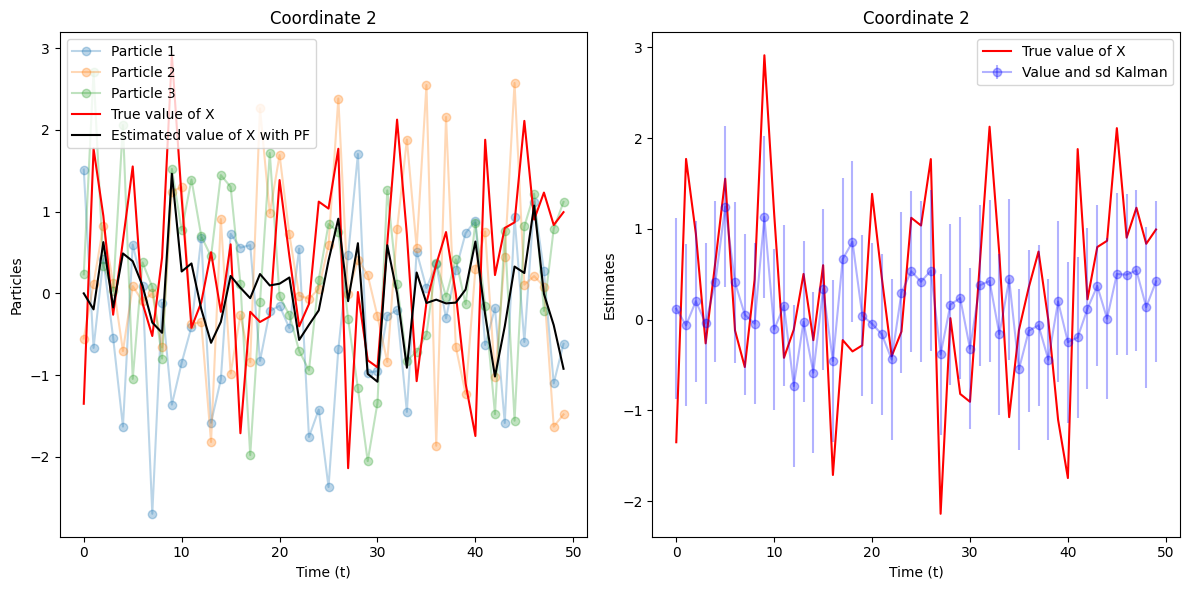

In [70]:
plot_results_2(1, particles, true_X, values_boot, sigma, mean)

Convergence of the BPF to the kalman filter

In [71]:
def RMSE(sequence, true_values):
  return (np.sqrt(sum((sequence-true_values)**2)/len(sequence)))

In [72]:
def RMSE_by_coordinate(seq1, seq2):
  D = len(seq1.transpose())
  T = len(seq1)
  res = []
  for i in range (D):
    res.append(RMSE(np.array(seq1).transpose()[i][1:], np.array(seq2).transpose()[i][1:]))
  return(res)

In [73]:
def plot_kalman_smc_N_dim_d(D, T, A, B, var_eps, var_delta, N):
  #simulate the data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

  absciss = np.array([i for i in range (N)])
  to_plot = []

  #kalman filter
  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
  mu_x = res[0]

  #smc for different values of N
  for k in range (1, N):
    smc_x = np.array([np.empty([D,k]) for i in range (T)])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])

    res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

    RMSE = RMSE_by_coordinate(mu_x, res_smc)

    to_plot.append(RMSE)

  to_plot = np.array(to_plot).transpose()
  for i in range(len(to_plot)): #len(to_plot) = D
    plt.plot(np.log(absciss[1:]), np.log(to_plot[i]), '-', label='Coordinate {}'.format(i+1), alpha = 0.5)
  plt.plot(np.log(absciss[1:]), np.log(np.mean(to_plot, axis = 0)), color = 'black')
  plt.xlabel('Number of particles')
  plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Convergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

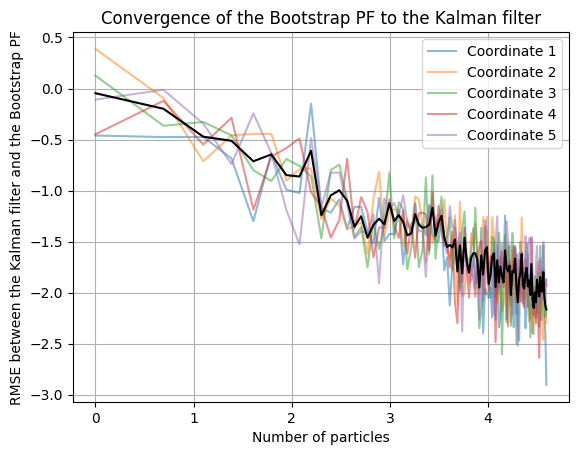

In [74]:
plot_kalman_smc_N_dim_d(5, 10, 0.2*np.identity(5), 0.4*np.identity(5), np.identity(5), np.identity(5), 100)

Again, we can average over several rounds to have a curve that is smoother

In [75]:
def boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B, X):
  to_return_kalman = []
  to_return_X = []
  for z in range (n_rep):
    smc_x = np.array([np.empty([D,k]) for i in range (T)])
    smc_w = np.empty([T,k])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/k for i in range (k)]])

    res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

    RMSE = RMSE_by_coordinate(mu_x, res_smc)
    to_return_kalman.append(RMSE)
    RMSE = RMSE_by_coordinate(X, res_smc)
    to_return_X.append(RMSE)

  return(np.mean(np.array(to_return_kalman), axis = 0), np.mean(np.array(to_return_X), axis = 0))


In [76]:
def plot_kalman_smc_N_dim_d_average(D, T, A, B, var_eps, var_delta, N, n_rep):
  #simulate the data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

  to_plot_kalman = []
  to_plot_X = []

  #kalman filter
  mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
  sigma_x = np.array([np.identity(D)])
  res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
  mu_x = res[0]

  #smc for different values of N
  for k in range (1, N):
    res_boucle = boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B, np.array(X))
    RMSE_kalman = res_boucle[0]
    RMSE_X = res_boucle[1]
    to_plot_kalman.append(RMSE_kalman)
    to_plot_X.append(RMSE_X)

  to_plot_kalman = np.array(to_plot_kalman).transpose()
  to_plot_X = np.array(to_plot_X).transpose()
  return(to_plot_kalman, to_plot_X)

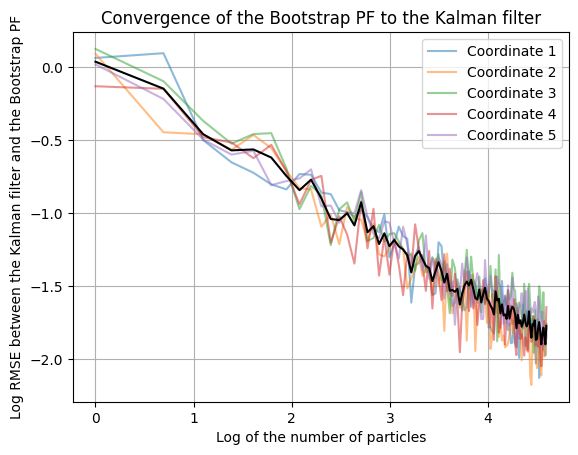

In [77]:
to_plot = plot_kalman_smc_N_dim_d_average(5, 10, 0.2*np.identity(5), 0.4*np.identity(5), np.identity(5), np.identity(5), 100, 5)[0]
absciss = np.array([i for i in range (100)])
for i in range(len(to_plot)): #len(to_plot) = D
    plt.plot(np.log(absciss[1:]), np.log(to_plot[i]), '-', label='Coordinate {}'.format(i+1), alpha = 0.5)
plt.plot(np.log(absciss[1:]), np.log(np.mean(to_plot, axis = 0)), color = 'black')
plt.xlabel('Log of the number of particles')
plt.ylabel('Log RMSE between the Kalman filter and the Bootstrap PF')
plt.title('Convergence of the Bootstrap PF to the Kalman filter')
plt.legend()
plt.grid(True)
plt.show()

Change the noise level

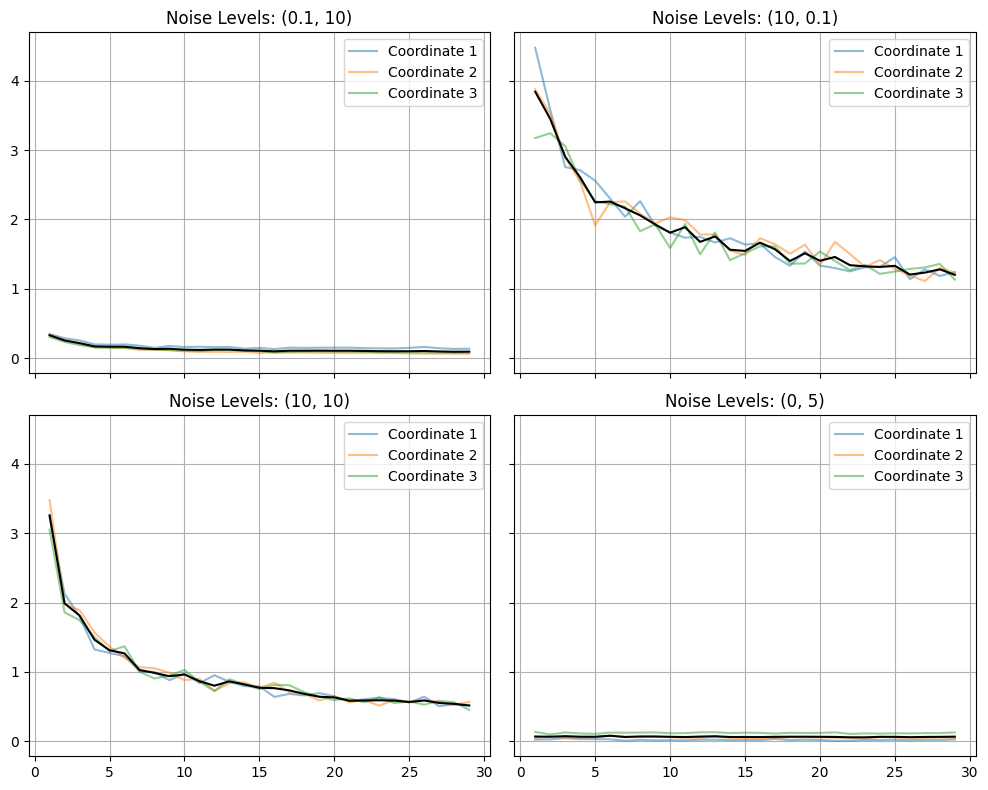

In [78]:
noise_levels = [[0.1, 10], [10, 0.1], [10, 10], [0, 5]]
N = 30
D = 3
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
absciss = np.array([i for i in range (N)])

for i in range (len(noise_levels)):
  to_plot = plot_kalman_smc_N_dim_d_average(D, 20, 0.2*np.identity(D), 0.4*np.identity(D), noise_levels[i][0]*np.identity(D), noise_levels[i][1]*np.identity(D), N, 5)[0]
  for z in range(len(to_plot)): #len(to_plot) = D
    axes[i // 2, i % 2].plot(absciss[1:], to_plot[z], '-', label='Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

plot the RMSE with respect to the true values of X 

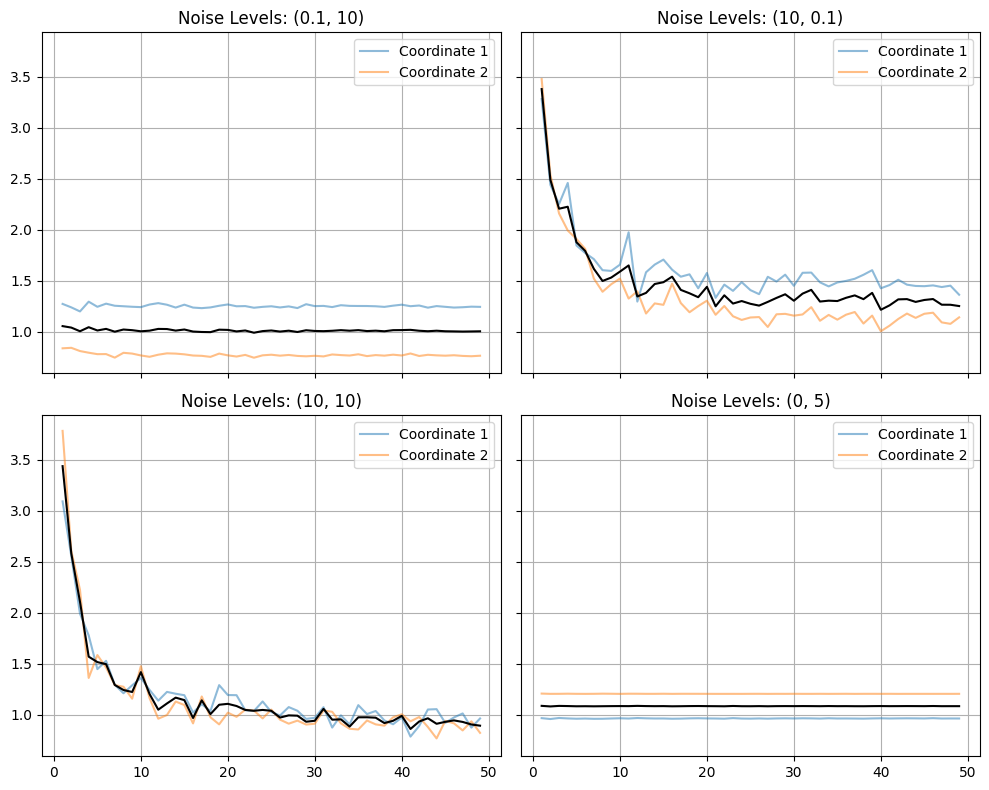

In [79]:
noise_levels = [[0.1, 10], [10, 0.1], [10, 10], [0, 5]]
N = 50
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
absciss = np.array([i for i in range (N)])

for i in range (len(noise_levels)):
  res = plot_kalman_smc_N_dim_d_average(2, 10, 0.2*np.identity(2), 0.4*np.identity(2), noise_levels[i][0]*np.identity(2), noise_levels[i][1]*np.identity(2), N, 5)
  to_plot = res[1]
  for z in range(len(to_plot)): #len(to_plot) = D
    axes[i // 2, i % 2].plot(absciss[1:], to_plot[z], '-', label='Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

**Fully adapted SMC**

In [80]:
#kalman filter step for the fapf
def kalman_filter_fapf_step(mu_x, sigma_x, A, C, Q, R, true_Y):
    #prediction
    mu_x_ = np.dot(A, mu_x)
    Pt_x_ = np.array(np.dot(np.dot(A, sigma_x),A.transpose()) + Q)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x), C.transpose()) + R))
    mu_x_new = mu_x_ + np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), (true_Y - np.dot(C, mu_x_)))
    Pt_x_new = Pt_x_ - np.dot(np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), C), Pt_x_)
    return (mu_x_new, Pt_x_new)

In [81]:
def p_ycurr_xcurr(y_current, x_current, B, R): #testé ok, good
    return([multivariate_normal.pdf(y_current, mean = np.dot(B, x_current[i]), cov= R) for i in range (len(x_current))])

def p_ycurr_xprev(y_current, x_previous, B, R, A, Q):
    return([multivariate_normal.pdf(y_current, mean = np.dot(B,np.dot(A, x_previous[i])), cov = np.dot(np.dot(B, Q), B.transpose()) + R) for i in range (len(x_previous))])

def p_xcurr_xprev(x_current, x_previous,A,Q):
    return([multivariate_normal.pdf(x_current[i], mean = np.dot(A, x_previous[i]) , cov = Q) for i in range (len(x_current))])

def q_xcurr_xprev_ycurr(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = []
    res = []
    for i in range (len(x_previous)):
        values = kalman_filter_fapf_step(x_previous[i], sigma_previous, A, B, Q, R, y_curr) #i do the kalman filter for each which gives me the new x and cov matrix
        res.append(multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]))
    return(np.array(res))

def q_xcurr_xprev_ycurr_init(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = kalman_filter_fapf_step(x_previous, sigma_previous, A, B, Q, R, y_curr)
    return(np.array([multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]) for i in range (len(x_current))]))

def w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc):
    return(p_yc_xc*p_xc_xp/(p_yc_xp*q_xc_xp_yc)) #dans l'idée, voir les dimensions

    

In [82]:
def fully_adapted(x_0, true_Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, Q, R, N): #on donne x et y les valeurs à t=0, N nombre de particules qu'on veut
  #initialization
  D = np.shape(A)[0]
  T = len(true_Y)
  estimate = np.empty([T,D])
  x = np.empty([T, N, D])
  kalman_res = kalman_filter_fapf_step(x_0, np.identity(D), A, B, Q, R, true_Y[0])
  kalman_res_mean = np.array([kalman_res[0]])
  kalman_res_cov = np.array([kalman_res[1]])
  x[0] = np.array([npr.multivariate_normal(kalman_res_mean[0], kalman_res_cov[0], N)])
  w = np.empty([T, N])
  w[0] = np.array([p_ycurr_xcurr(true_Y[0], x[0], B, R)/np.array(q_xcurr_xprev_ycurr_init(x[0], x_0, true_Y[0], A, B, Q, R, np.identity(D)))])
  w[0] = w[0]/sum(w[0]) #normalize weights
  nu = np.empty([T, N]) #adjustment multipliers
  estimate[0] = x_0

  #for loop
  for t in range (1, T):
    #adjustement multipliers
    nu[t-1] = np.array(p_ycurr_xprev(true_Y[t], x[t-1], B, R, A, Q)) 
    #resample
    weights = [nu[t-1][i]*w[t-1][i] for i in range (N)] #nouveaux weights pour cette étape
    weights = weights/sum(weights)
    resample = multinomial_resampling_d(x[t-1], weights, N).transpose() #on a N particules
    #propagate
    for i in range (len(resample)):
      kalman_res = kalman_filter_fapf_step(resample[i], np.identity(D), A, B, Q, R, true_Y[t])
      #kalman_res = np.append(kalman_res, np.array([kalman_filter_fapf_step(resample[i], kalman_res[t-1][i], A, B, Q, R, true_Y[t]) for i in range (len(resample))]))
      x[t][i] = npr.multivariate_normal(kalman_res[0], kalman_res[1],1) 
    #weight
    p_yc_xc = np.array(p_ycurr_xcurr(Y[t], x[t], B, R))
    p_yc_xp = np.array(p_ycurr_xprev(Y[t], x[t], B, R, A, Q))
    p_xc_xp = np.array(p_xcurr_xprev(x[t], x[t-1],A,Q))
    q_xc_xp_yc = np.array(q_xcurr_xprev_ycurr(x[t], x[t-1], Y[t], A, B, Q, R, np.identity(D)))
    w[t] = w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc) #calculer le ratio : mais ici ya des choses qui se simplifient et on a seulement p(y[t]|x[t]^i)
    w[t] = w[t]/sum(w[t])
    #w[t] = [1 for i in range (N)] #fapf you have weights equal to one : very strange
    #estimate the value
    estimate[t] = np.dot(w[t], x[t])

  return(x,w,estimate)


In [83]:
#simulate data
D = 3 #dimension
#simulate some data following a linear gaussian equation
x0 = np.array([npr.normal(0,1) for i in range (D)])
y0 = np.array([npr.normal(0,1) for i in range (D)])
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = 0.1*np.identity(D)

X = [x0]
true_Y = [y0]
for t in range (1,T):
  X.append(np.dot(A, X[t-1]) + np.array(npr.multivariate_normal(np.zeros(D), var_eps))) 
  true_Y.append(np.dot(B, X[t-1]) + np.array(npr.multivariate_normal(np.zeros(D), var_delta)))

N = 10
x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))


In [84]:
res = fully_adapted(x_0, true_Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, N)

In [85]:
#check that the weights are close to 1/N after the 1st step 'ie close to 0.1 here)
weights = res[1].transpose()

In [86]:
np.shape(weights)

(10, 50)

In [87]:
weights_new = np.empty(np.shape(weights))
for i in range (len(weights)):
    weights_new[i] = weights[i]/sum(weights[i])

weights_new

array([[0.00803875, 0.00738859, 0.00639769, 0.02287933, 0.01307936,
        0.02041565, 0.00415386, 0.02253664, 0.03358151, 0.03503442,
        0.02697704, 0.00928643, 0.0155572 , 0.01771863, 0.02227651,
        0.0030592 , 0.00495428, 0.01352476, 0.00441158, 0.03380742,
        0.01095354, 0.0173096 , 0.03882098, 0.02036926, 0.01187475,
        0.00971756, 0.01082371, 0.03435021, 0.00863352, 0.04640706,
        0.02751587, 0.01457474, 0.03052977, 0.01445504, 0.03519484,
        0.04406063, 0.09279387, 0.01743339, 0.02564994, 0.01367336,
        0.02790631, 0.0016723 , 0.02836033, 0.00958925, 0.00550903,
        0.02619253, 0.01089649, 0.00989799, 0.02623291, 0.00352235],
       [0.01403351, 0.04188244, 0.03127988, 0.01894292, 0.01902349,
        0.01983052, 0.01592152, 0.03822195, 0.00515253, 0.01099886,
        0.01292273, 0.02552468, 0.0828688 , 0.01512585, 0.0051806 ,
        0.01069433, 0.01527568, 0.03885025, 0.00580006, 0.02613656,
        0.03046886, 0.02311591, 0.00722937, 0.0

In [88]:
#compute the ESS
ESS = np.array(1/np.sum(weights_new**2, axis = 1))

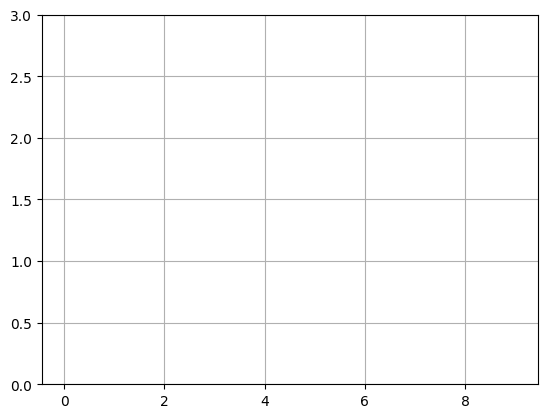

In [89]:
plt.plot(ESS)
plt.ylim(0,3)
plt.grid(True)

In [90]:
values_boot = res[2]
particles = res[0]
true_X = X

In [91]:
np.shape(particles) #good

(50, 10, 3)

In [92]:
#plotting the results for any coordinate
def plot_results_fully(coordinate, particles, true_X, values_boot):
  T = len(true_X)
  to_plot_coordinate = [particles[0].transpose()[coordinate]]
  for i in range (1, len(particles)):
    to_plot_coordinate.append(particles[i].transpose()[coordinate])
  to_plot_coordinate = np.array(to_plot_coordinate)

  x_abs = np.array([i for i in range(T)])
  for i in range(to_plot_coordinate.shape[1]):
    plt.plot(x_abs, to_plot_coordinate[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.5)
  plt.plot(np.array(true_X).transpose()[1], color = 'red', label = 'True value of X')
  plt.plot(np.array(values_boot).transpose()[1], color = 'black', label = 'Estimated value of X with the Fully APF')
  #plt.plot(np.array(mean).transpose()[1], color = 'blue', label = 'Estimated mean Kalman')
  #plt.errorbar(x_abs, np.array(mean).transpose()[1], yerr=sigma[:,1][:,1], fmt='o-', color = 'blue', label = 'Value and sd Kalman')
  plt.xlabel('Time (t)')
  plt.ylabel('Particles')
  plt.title('Coordinate {}'.format(coordinate+1))
  plt.legend()
  plt.grid(True)
  plt.show()


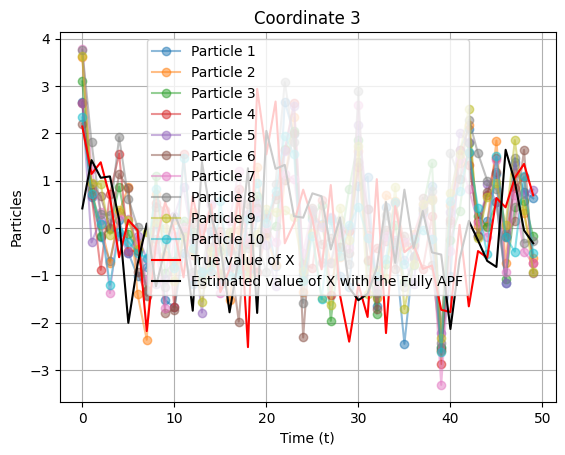

In [93]:
plot_results_fully(2, particles, true_X, values_boot)

*Plot the results for Kalman, PF, Fully APF*

In [94]:
def compare_kalman_pf_fapf(d, D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + np.array(npr.multivariate_normal(np.zeros(D), var_eps))) #for the noise since we took the identity matrix
        Y.append(np.dot(B, X[t]) + np.array(npr.multivariate_normal(np.zeros(D), var_delta)))
    
    X = np.array(X).transpose()

    #kalman filter 
    mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
    sigma_x = np.array([np.identity(D)])
    res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
    mu_x = np.array(res[0]).transpose()

    #bootstrap filter
    smc_x = np.array([np.empty([D,N]) for i in range (T)])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])
    res_boot = np.array(bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, N,B)[2]).transpose()

    #APF
    x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
    res_apf = np.array(fully_adapted(x_0, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, N)[2]).transpose()
    
    #compute the RMSE compared with the true values for each method 
    #RMSE_kalman = 
    #RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
    #RMSE_apf = RMSE_by_coordinate(mu_x, res_smc)
    

    x_abs = [i for i in range (T)]
    plt.plot(x_abs[1:], X[d][1:], label = 'X')
    plt.plot(x_abs[1:], mu_x[d][1:], label = 'Kalman')
    plt.plot(x_abs[1:], res_boot[d][1:], label = 'BPF')
    plt.plot(x_abs[1:], res_apf[d][1:], label = 'FAPF')
    plt.legend()
    plt.title('Coordinate {}'.format(d+1))
    plt.grid(True)


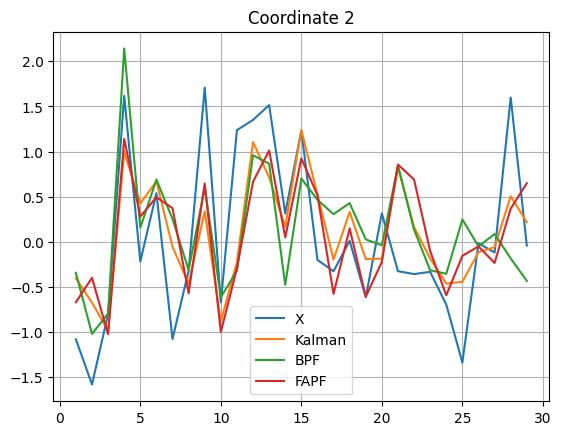

In [95]:
compare_kalman_pf_fapf(1, 3, 30, A, B, var_eps, var_delta, 10, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)

Plot the RMSE as N grows

In [96]:
def compare_kalman_pf_fapf_RMSE(D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
        Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    

    absciss = np.array([i for i in range (N)])
    to_plot_smc = []
    to_plot_apf = []

    #kalman filter 
    mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
    sigma_x = np.array([np.identity(D)])
    res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
    mu_x = np.array(res[0])

    #bootstrap filter and APF for different values of N
    for k in range (1, N):
        smc_x = np.array([np.empty([D,k]) for i in range (T)])
        smc_w = np.empty([T,k])
        smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
        smc_w[0] = np.array([[1/k for i in range (k)]])
        res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

        RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
        to_plot_smc.append(RMSE_smc)


        #APF
        x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
        res_apf = fully_adapted(x_0, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, k)[2]
        RMSE_apf = RMSE_by_coordinate(mu_x, res_apf)
        to_plot_apf.append(RMSE_apf)

    to_plot_smc = np.array(to_plot_smc).transpose()
    to_plot_apf = np.array(to_plot_apf).transpose()
    for i in range(len(to_plot_smc)): #len(to_plot) = D
        plt.plot(absciss[1:], to_plot_smc[i], '-', label='BPF Coordinate {}'.format(i+1), alpha = 0.5)
        plt.plot(absciss[1:], to_plot_apf[i], '-', label='APF Coordinate {}'.format(i+1), alpha = 0.5)
    plt.plot(absciss[1:], np.mean(to_plot_smc, axis = 0), color = 'black', label = 'Bootstrap PF')
    plt.plot(absciss[1:], np.mean(to_plot_apf, axis = 0), color = 'blue', label = 'APF')
    plt.xlabel('Number of particles')
    plt.ylabel('RMSE between the Kalman filter and the PF considered')
    plt.title('Convergence of the particles filter to the Kalman filter')
    plt.legend()
    plt.grid(True)
    plt.show()


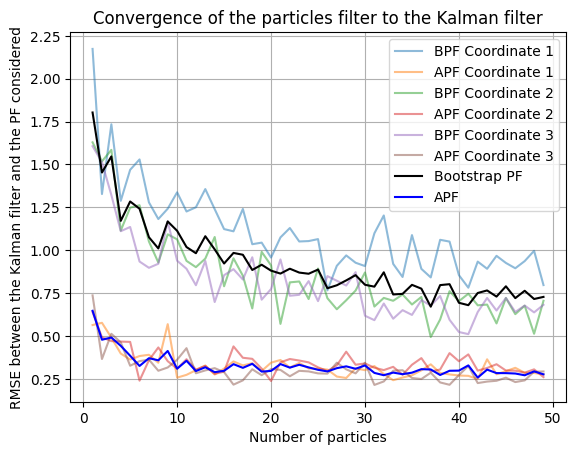

In [97]:
compare_kalman_pf_fapf_RMSE(3, 30, A, B, var_eps, var_delta, 50, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)

APF performs way better when there is few measurement error (var_delta = 0.1*id, var_eps = id)

**Plot with different noise values**

In [98]:
def compare_kalman_pf_fapf_RMSE_not_plot(D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
        Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    

    absciss = np.array([i for i in range (N)])
    to_plot_smc = []
    to_plot_apf = []

    #kalman filter 
    mu_x = np.array([[npr.normal(0,1) for i in range (D)]])
    sigma_x = np.array([np.identity(D)])
    res = kalman_filter_d(mu_x, sigma_x, A, B, var_eps, var_delta, Y, T)
    mu_x = np.array(res[0])

    #bootstrap filter and APF for different values of N
    for k in range (1, N):
        smc_x = np.array([np.empty([D,k]) for i in range (T)])
        smc_w = np.empty([T,k])
        smc_x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (k)]).transpose() #for each time we have N particles which have a value
        smc_w[0] = np.array([[1/k for i in range (k)]])
        res_smc = bootstrap_filter_d(smc_x, smc_w, Y, T, A, var_eps, var_delta, D, k,B)[2]

        RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
        to_plot_smc.append(RMSE_smc)


        #APF
        x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
        res_apf = fully_adapted(x_0, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, k)[2]
        RMSE_apf = RMSE_by_coordinate(mu_x, res_apf)
        to_plot_apf.append(RMSE_apf)

    to_plot_smc = np.array(to_plot_smc).transpose()
    to_plot_apf = np.array(to_plot_apf).transpose()

    return(to_plot_smc, to_plot_apf, np.array(X), mu_x, res_smc, res_apf)

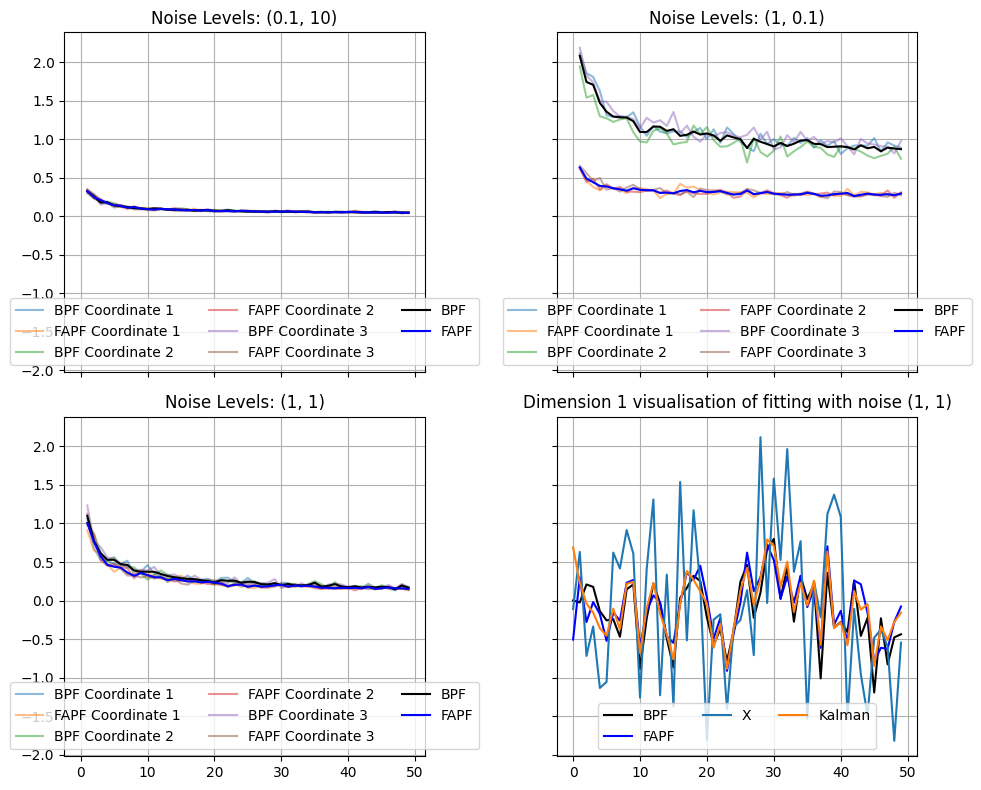

In [99]:
noise_levels = [[0.1, 10], [1, 0.1], [1, 1]]
N = 50
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
absciss = np.array([i for i in range (N)])
D = 3

for i in range (len(noise_levels)):
  res = compare_kalman_pf_fapf_RMSE_not_plot(D, 50, A, B, noise_levels[i][0]*np.identity(D), noise_levels[i][1]*np.identity(D), N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)
  to_plot_smc = res[0]
  to_plot_apf = res[1]
  for z in range(len(to_plot_smc)): #len(to_plot) = D
    axes[i // 2, i % 2].plot(absciss[1:], to_plot_smc[z], '-', label='BPF Coordinate {}'.format(z+1), alpha = 0.5)
    axes[i // 2, i % 2].plot(absciss[1:], to_plot_apf[z], '-', label='FAPF Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot_smc, axis = 0), color = 'black', label = 'BPF')
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot_apf, axis = 0), color = 'blue', label = 'FAPF')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend(loc = 'lower center', ncols = 3)

X = res[2]
mu_x = res[3]
res_smc = res[4]
res_apf = res[5]
axes[1,1].plot(absciss, np.array(res_smc).transpose()[0], color = 'black', label = 'BPF')
axes[1,1].plot(absciss, np.array(res_apf).transpose()[0], color = 'blue', label = 'FAPF')
axes[1,1].plot(absciss, np.array(X).transpose()[0], label = 'X')
axes[1,1].plot(absciss, np.array(mu_x).transpose()[0], label = 'Kalman')
axes[1,1].set_title('Dimension 1 visualisation of fitting with noise (1, 1)')
axes[1,1].grid(True)
axes[1,1].legend(loc = 'lower center', ncols = 3)


plt.tight_layout()
plt.show()


**Nested smc**

In [ ]:
#forward filtering
def forward_filter(target, prop, prop_init, M, true_x, true_y,n): #n is nx
    x = [prop_init(true_x[0]) for i in range (M)] #sample according to the proposal
    w = [target(x[0][i])/prop_init(x[0][i]) for i in range (len(x[0]))]
    for d in range (1, n):
        #multinomial resampling

        #concatenation 

        #weighting

#it's just a normal filtering algorithm ? or am i stupid ?

In [ ]:
#backward simulation
def backward_simul(particles, weights): #we have approximation of p1(x1); p2(x1:2)... 
    new_vector = []
    inverted_vector = []
    n = len(particles)
    #resample the particles in the last vector
    res = multinomial_resampling(weights[n], particles[n])[0] #pour récupérer les particules 
    weights_new = []
    for k in range (n-1, 1, -1):
        weights_new = [weights[k]] #need to add the ratio of densities
        res = multinomial_resampling(weights_new, particles[k])
        new_vector.append()
        



In [ ]:
#nested smc
def nested_sequential(eta, kappa, tau):
    #to do 

# Annexes

**question à poser : dans ce site http://www.eie.polyu.edu.hk/~mwmak/EIE6207/KalmanFilter-beamer.pdf, ce que nous on appelle mu_t ils disent que c'est la prédiction de x_t. Dans le poly 'learning of dynamical systems', on utilise le x_t+1 mais ici on n'a pas accès à x_t+1. Donc j'ai tendance à dire qu'on est dans le cas 1 et que mu_x représente en réalité l'estimation de x à partir de z. sigma représente la variance de l'erreur de prédiction.**